In [45]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from skimage import io
import seaborn as sns

from microscopy import utils 

import omegaconf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def translate_yaml(yaml_path):

    confg = omegaconf.OmegaConf.load(yaml_path)

    result = {}

    hyperparams = confg.pop('used_optim')
    result.update(hyperparams)
    hyperparams = confg.pop('used_model')
    result.update(hyperparams)
    hyperparams = confg.pop('used_dataset')
    result.update(hyperparams)

    patience = confg.pop('model.optim.early_stop.patience')
    result.update({'patience':patience})
    
    hyperparams = confg.pop('hyperparam')
    result.update(hyperparams)

    confg.pop('dataset')
    confg.pop('model')

    result.update(confg)

    result.pop('data_paths')
    
    return result

def load_test_results(test_metrics_path):
    metric_dict= {}
    
    for metric in os.listdir(test_metrics_path):
        metric_name = metric[:-4]
        metric_data = np.load(os.path.join(test_metrics_path, metric))
        metric_dict[f'{metric_name}_mean'] = np.mean(metric_data) if len(metric_data) > 0 else 0
        metric_dict[f'{metric_name}_std'] = np.std(metric_data) if len(metric_data) > 0 else 0
    return metric_dict
        

def sorted_imgs_by_epoch(filename_list):
    epochs = [int(e[:-4]) for e in filename_list]
    return [f'{e}.png' for e in sorted(epochs)]

In [56]:
results_path = os.path.abspath('results')

if not os.path.exists(results_path):
    raise ValueError('There is no results folder.')

dataset_list = os.listdir(results_path)
dataset_path_list = [os.path.join(results_path, e) for e in os.listdir(results_path)]

all_results = {}

for dataset, dataset_path in zip(dataset_list, dataset_path_list):
    model_list = os.listdir(dataset_path)
    model_path_list = [os.path.join(dataset_path, e) for e in os.listdir(dataset_path)]
    for model, model_path in zip(model_list, model_path_list):
        additfolder_list = os.listdir(model_path)
        additfolder_path_list = [os.path.join(model_path, e) for e in os.listdir(model_path)]
        cont = 0
        for additfolder, additfolder_path in zip(additfolder_list, additfolder_path_list):
            config_list = os.listdir(additfolder_path)
            config_path_list = [os.path.join(additfolder_path, e) for e in os.listdir(additfolder_path)]
            for config, config_path in zip(config_list, config_path_list):
                yaml_path = os.path.join(config_path, 'train_configuration.yaml')
                test_metrics_path = os.path.join(config_path, 'test_metrics')
                
                if os.path.exists(yaml_path) and os.path.exists(test_metrics_path):
                    # hydra_conf = omegaconf.OmegaConf.load('/data/ihidalgo/MicroscoPy/conf/config.yaml')
                    # hydra_dict = omegaconf.OmegaConf.to_container(hydra_conf, resolve=True)

                    # yaml_data.update(load_test_results(test_metrics_path))
                    # yaml_data.update({'config_path': config_path})
                    hydra_conf = translate_yaml(yaml_path)
                    hydra_conf.update(load_test_results(test_metrics_path))
                    hydra_conf.update({'config_path': config_path})
                    all_results[f'{model}_{dataset}_{cont}'] = hydra_conf

                    cont += 1

In [57]:
df = pd.DataFrame(all_results).T
df.head()

beta1 beta2 epsilon depth init_channels maxpooling  \
unet_ER_0                  0.5   0.9     0.0     4            16      False   
unet_LiveFActinDataset_0   0.5   0.9     0.0     4            16      False   
unet_F-actin_0             0.5   0.9     0.0     4            16      False   

                         upsample_method      crappifier patch_size_x  \
unet_ER_0                 SubpixelConv2D  downsampleonly           64   
unet_LiveFActinDataset_0  SubpixelConv2D  downsampleonly          128   
unet_F-actin_0            SubpixelConv2D  downsampleonly           64   

                         patch_size_y scale patience  \
unet_ER_0                          64  None      100   
unet_LiveFActinDataset_0          128  None      100   
unet_F-actin_0                     64  None      100   

                                             test_metric_indexes optimizer  \
unet_ER_0                 [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]      adam   
unet_LiveFActinDataset_0  [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]      adam   
unet_F-actin_0            [69, 7, 36, 75, 74, 30, 12, 42, 87, 0]      adam   

                         discriminator_optimizer scheduler  \
unet_ER_0                                   adam  OneCycle   
unet_LiveFActinDataset_0                    adam  OneCycle   
unet_F-actin_0                              adam  OneCycle   

                         discriminator_lr_scheduler     lr discriminator_lr  \
unet_ER_0                                  OneCycle  0.001            0.001   
unet_LiveFActinDataset_0                   OneCycle  0.001            0.001   
unet_F-actin_0                             OneCycle  0.001            0.001   

                         seed batch_size num_epochs validation_split  \
unet_ER_0                 666         16        100              0.1   
unet_LiveFActinDataset_0  666         16        100              0.1   
unet_F-actin_0            666         16        100              0.1   

                         additional_folder  \
unet_ER_0                             None   
unet_LiveFActinDataset_0              None   
unet_F-actin_0                        None   

                                                   data_augmentation  \
unet_ER_0                 [rotation, horizontal_flip, vertical_flip]   
unet_LiveFActinDataset_0  [rotation, horizontal_flip, vertical_flip]   
unet_F-actin_0            [rotation, horizontal_flip, vertical_flip]   

                         datagen_sampling_pdf       dataset_name model_name  \
unet_ER_0                                   0                 ER       unet   
unet_LiveFActinDataset_0                    0  LiveFActinDataset       unet   
unet_F-actin_0                              0            F-actin       unet   

                         actual_scale_factor    input_data_shape  \
unet_ER_0                                  2    [288, 64, 64, 1]   
unet_LiveFActinDataset_0                   1  [753, 128, 128, 1]   
unet_F-actin_0                             2    [372, 64, 64, 1]   

                           output_data_shape  vgg_mean   vgg_std  mse_mean  \
unet_ER_0                 [288, 128, 128, 1]  0.514766   0.06041  0.011979   
unet_LiveFActinDataset_0  [753, 128, 128, 1]  0.631598  0.065033  0.004528   
unet_F-actin_0            [372, 128, 128, 1]  0.534749  0.012148   0.01198   

                           mse_std alex_mean  alex_std  psnr_mean  psnr_std  \
unet_ER_0                 0.003037  0.346275  0.064796  19.377967  1.235363   
unet_LiveFActinDataset_0  0.002945  0.615926  0.128994  24.161882  2.524437   
unet_F-actin_0            0.004028  0.264647  0.024718  19.467347  1.494462   

                         ssim_mean  ssim_std  \
unet_ER_0                 0.498046  0.089039   
unet_LiveFActinDataset_0  0.574369  0.110284   
unet_F-actin_0            0.446687  0.045074   

                                                                config_path  
unet_ER_0                 /data/ihidalgo/MicroscoPy/resul

In [58]:
# All possible configurations (not showing columns with single repeated value)
visualize_df = df.copy()
nunique = visualize_df.nunique()
cols_to_drop = nunique[nunique == 1].index
visualize_df.drop(cols_to_drop, axis=1)


patch_size_x patch_size_y scale additional_folder  \
unet_ER_0                          64           64  None              None   
unet_LiveFActinDataset_0          128          128  None              None   
unet_F-actin_0                     64           64  None              None   

                               dataset_name actual_scale_factor  \
unet_ER_0                                ER                   2   
unet_LiveFActinDataset_0  LiveFActinDataset                   1   
unet_F-actin_0                      F-actin                   2   

                            input_data_shape   output_data_shape  vgg_mean  \
unet_ER_0                   [288, 64, 64, 1]  [288, 128, 128, 1]  0.514766   
unet_LiveFActinDataset_0  [753, 128, 128, 1]  [753, 128, 128, 1]  0.631598   
unet_F-actin_0              [372, 64, 64, 1]  [372, 128, 128, 1]  0.534749   

                           vgg_std  mse_mean   mse_std alex_mean  alex_std  \
unet_ER_0                  0.06041  0.011979  0.003037  0.346275  0.064796   
unet_LiveFActinDataset_0  0.065033  0.004528  0.002945  0.615926  0.128994   
unet_F-actin_0            0.012148   0.01198  0.004028  0.264647  0.024718   

                          psnr_mean  psnr_std ssim_mean  ssim_std  \
unet_ER_0                 19.377967  1.235363  0.498046  0.089039   
unet_LiveFActinDataset_0  24.161882  2.524437  0.574369  0.110284   
unet_F-actin_0            19.467347  1.494462  0.446687  0.045074   

                                                                config_path  
unet_ER_0                 /data/ihidalgo/MicroscoPy/results/ER/unet/scal...  
unet_LiveFActinDataset_0  /data/ihidalgo/MicroscoPy/results/LiveFActinDa...  
unet_F-actin_0            /data/ihidalgo/MicroscoPy/results/F-actin/unet...

# Analyze a single configuration

In [59]:
select_config = 'unet_ER_0'
config_df = df.loc[select_config]

train_metrics_path = os.path.join(config_df['config_path'], 'train_metrics')
train_images_path = os.path.join(config_df['config_path'], 'training_images')
test_metrics_path = os.path.join(config_df['config_path'], 'test_metrics')
predicted_images_path = os.path.join(config_df['config_path'], 'predicted_images')

print(config_df)

beta1                                                                       0.5
beta2                                                                       0.9
epsilon                                                                     0.0
depth                                                                         4
init_channels                                                                16
maxpooling                                                                False
upsample_method                                                  SubpixelConv2D
crappifier                                                       downsampleonly
patch_size_x                                                                 64
patch_size_y                                                                 64
scale                                                                      None
patience                                                                    100
test_metric_indexes                     

### Visualization of the training information

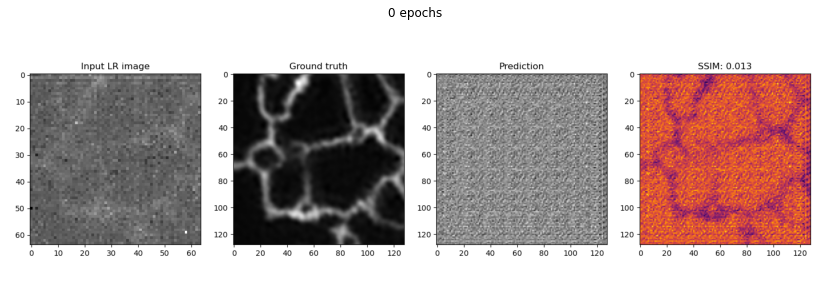

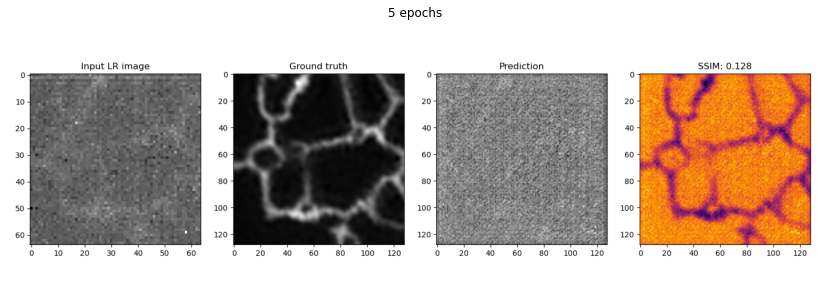

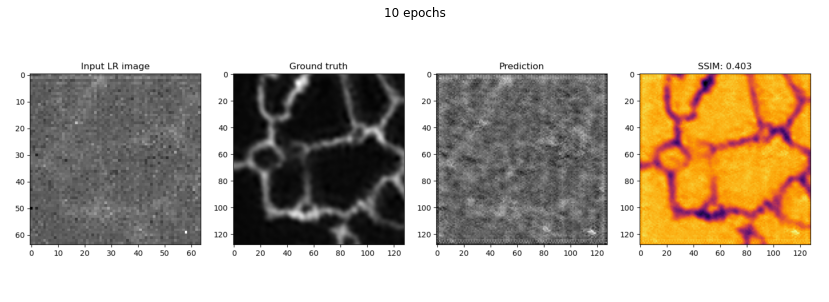

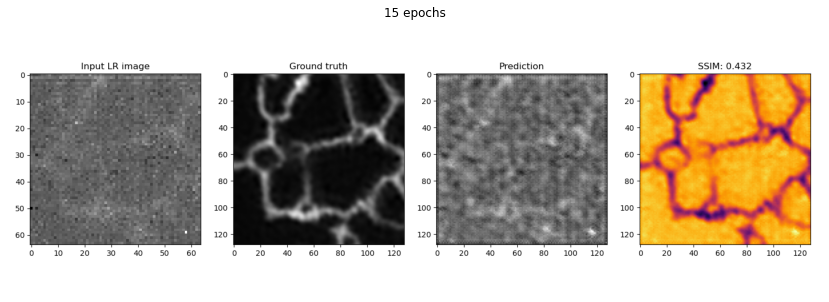

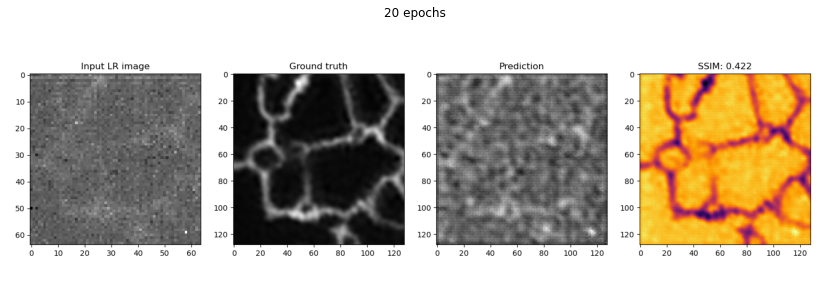

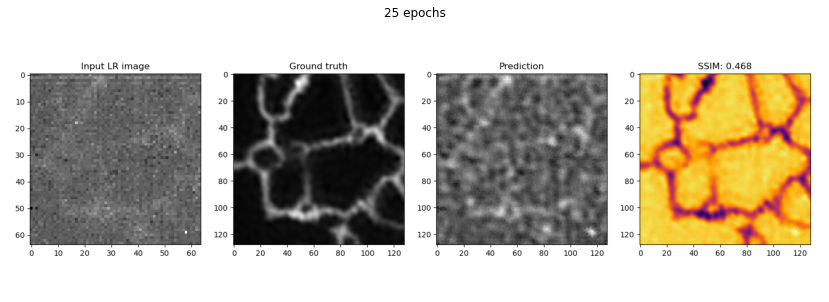

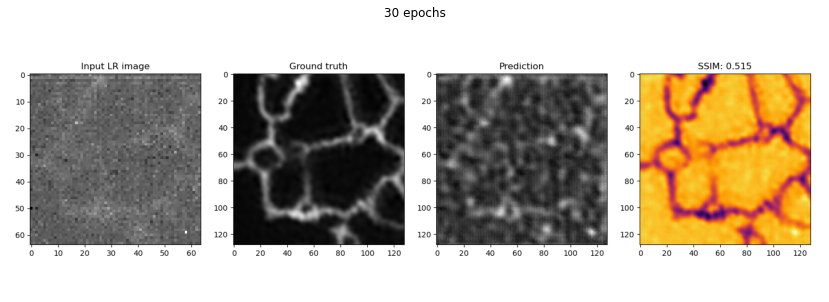

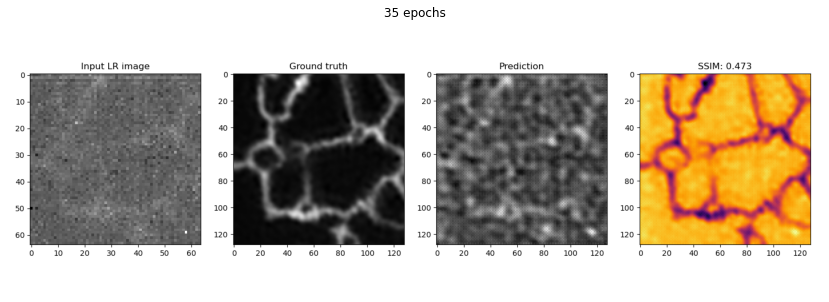

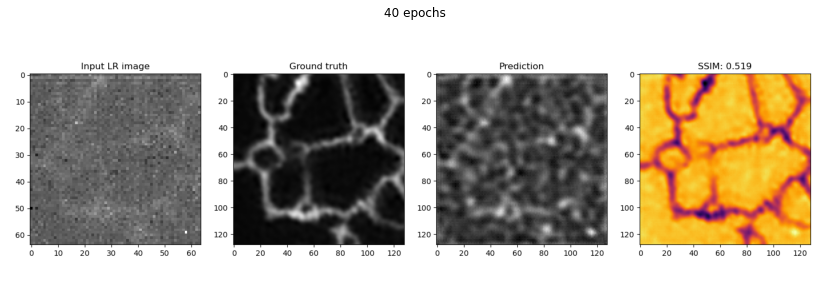

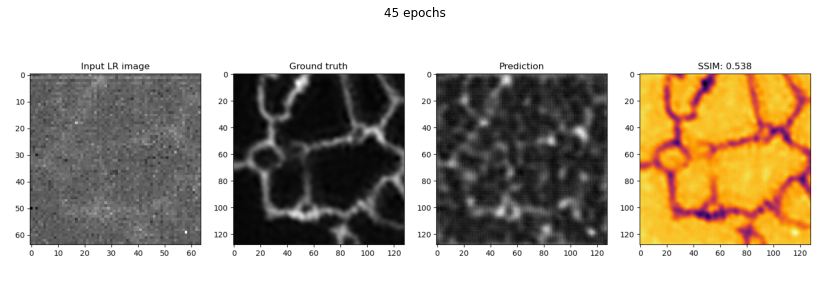

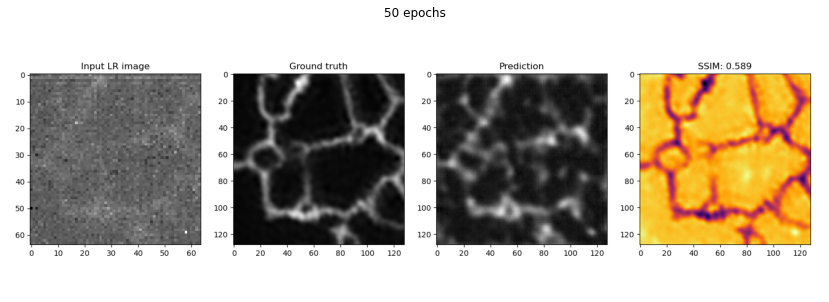

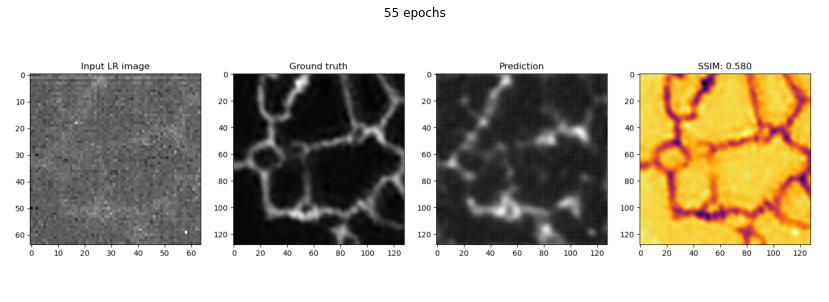

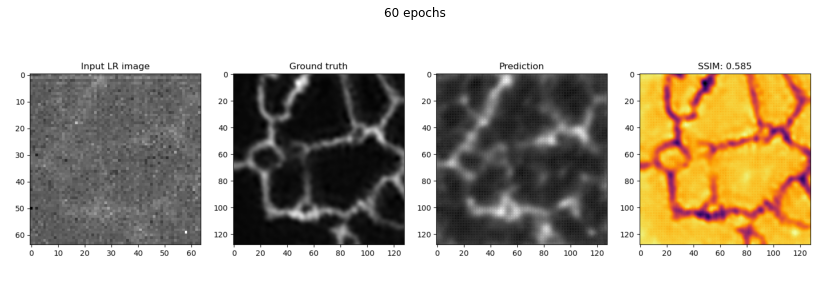

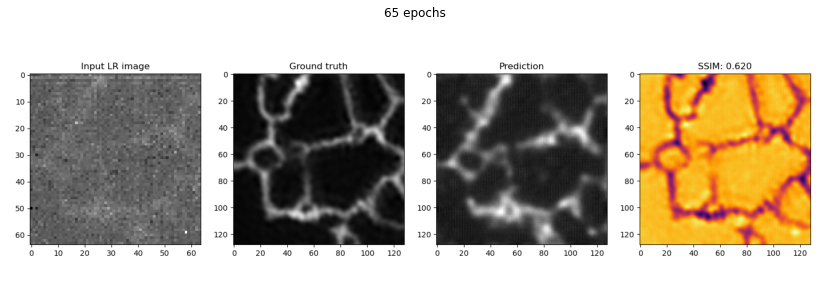

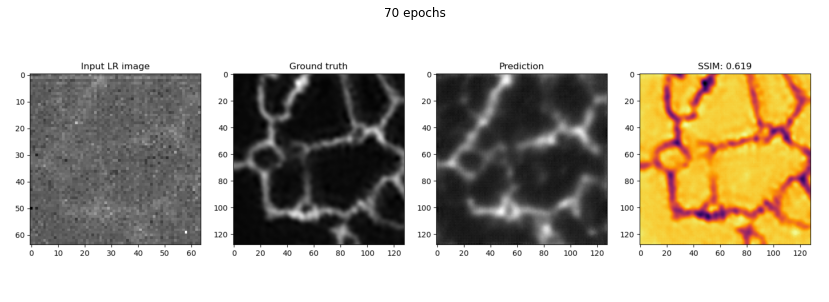

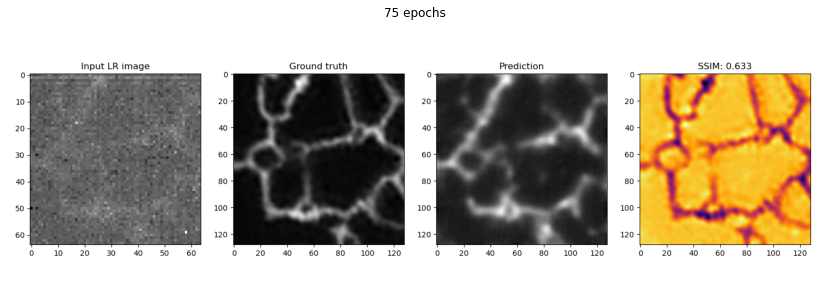

In [60]:
for f in sorted_imgs_by_epoch(os.listdir(train_images_path)):
    img_path = os.path.join(train_images_path, f)

    plt.figure(figsize=(15,5))
    plt.imshow(io.imread(img_path))
    plt.title(f[:-4] + ' epochs')
    plt.axis('off')
    plt.show()

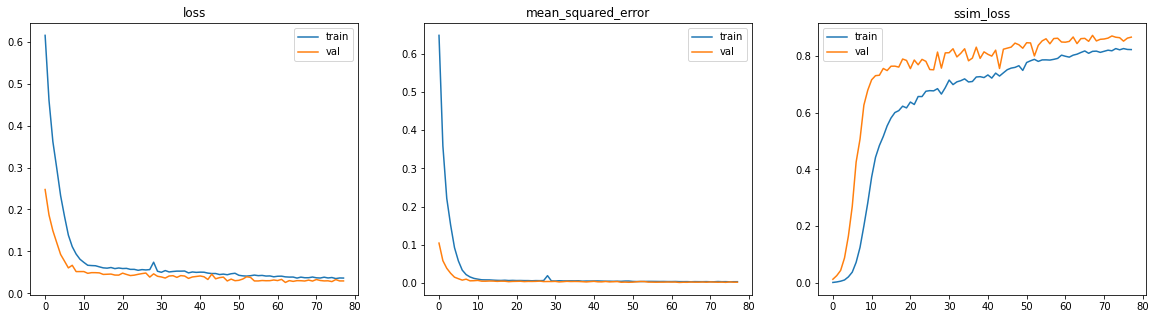

In [62]:
if config_df.model_name == 'wgan':
    metric_list = ['d_wasserstein', 'g_loss', 'g_l1']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}_epoch.npy'))
        val_loss = np.load(os.path.join(train_metrics_path, f'val_{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        sns.lineplot(x=np.arange(len(val_loss)), y=val_loss, label='val')
        plt.title(metric)
    plt.show()

    metric_list = ['d_loss_epoch', 'd_fake_epoch', 'd_real_epoch', 'd_gp_epoch']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        plt.title(metric)
    plt.show()

    metric_list = ['g_loss_epoch', 'g_l1_epoch', 'd_wasserstein_epoch', 'g_adv_loss_epoch']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        plt.title(metric)
    plt.show()

else:
    metric_list = ['loss', 'mean_squared_error', 'ssim_loss']

    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))
        val_loss = np.load(os.path.join(train_metrics_path, f'val_{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        sns.lineplot(x=np.arange(len(val_loss)), y=val_loss, label='val')
        plt.title(metric)

    plt.show()


### Visualization of the testing information

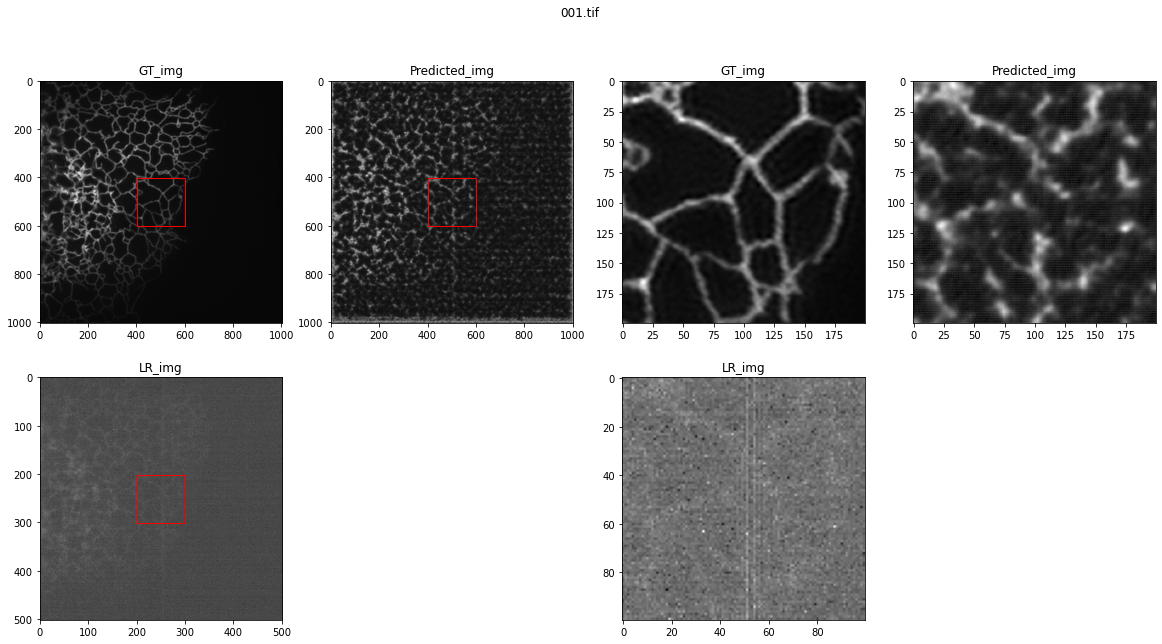

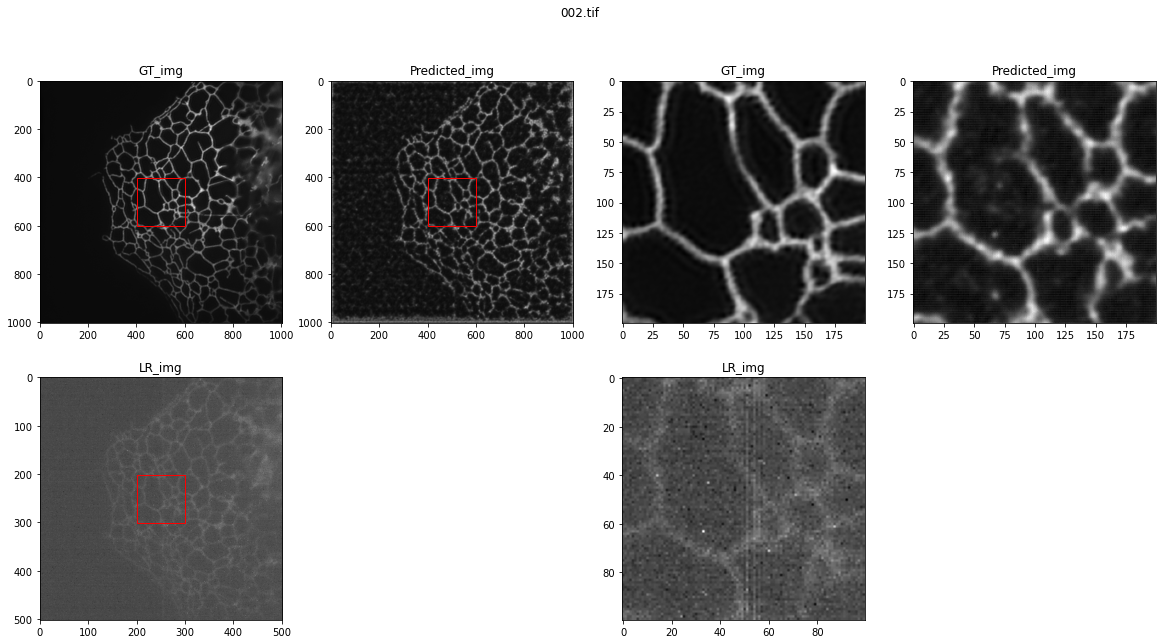

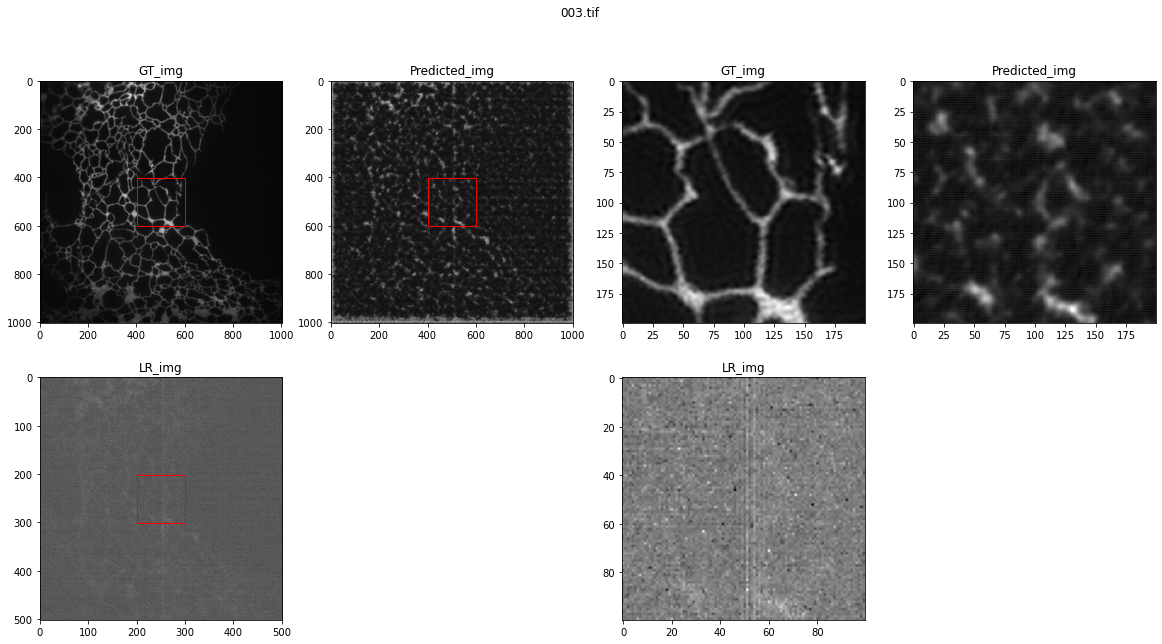

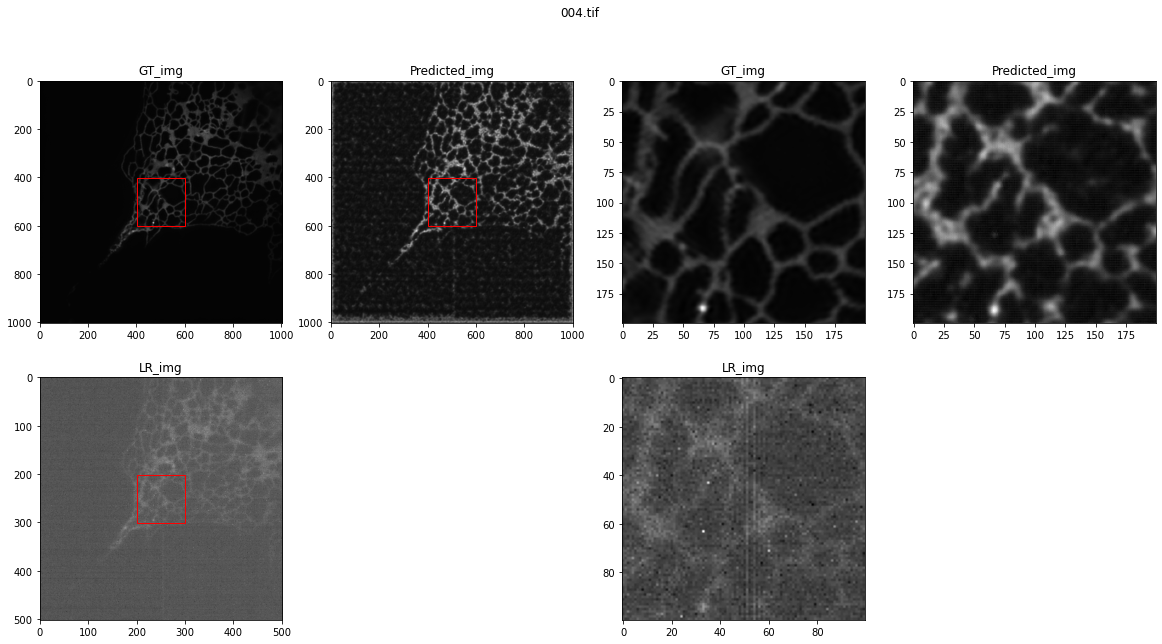

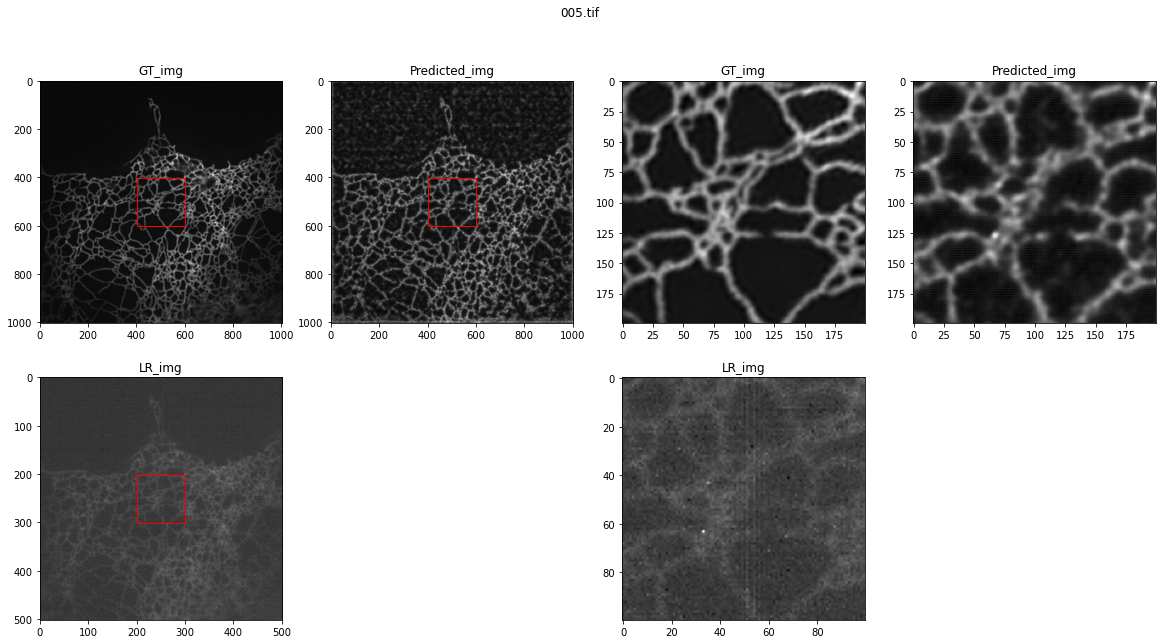

In [67]:
zoom_size = 100
center_point = None

dataset_config = utils.load_yaml('./conf/dataset/default.yaml')
dataset_root = 'datasets' if os.path.exists('datasets') else '../datasets'
dataset_name = config_df['dataset_name']
train_lr, train_hr, val_lr, val_hr, test_lr, test_hr = dataset_config[dataset_name]['data_paths']
test_lr_path = os.path.join(dataset_root, dataset_name, test_lr) if test_lr is not None else None
test_hr_path = os.path.join(dataset_root, dataset_name, test_hr) if test_hr is not None else None

for f in sorted(os.listdir(predicted_images_path))[:5]:
    img_path = os.path.join(predicted_images_path, f)
    gt_img_path = os.path.join(test_hr_path, f)
    wf_img_path = os.path.join(test_lr_path, f)

    img = io.imread(img_path)
    gt_img = io.imread(gt_img_path)
    wf_img = io.imread(wf_img_path)

    scale = gt_img.shape[0] // wf_img.shape[0]

    plt.figure(figsize=(20,10))

    gt_center_point = center_point if center_point is not None else (gt_img.shape[0]//2, gt_img.shape[1]//2)
    wt_center_point = (gt_center_point[0]//scale, gt_center_point[1]//scale)
    wf_zoom_size = zoom_size // scale

    plt.subplot(2,4,1)
    plt.imshow(gt_img, 'gray')
    plt.title('GT_img')
    ax = plt.gca()
    ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                            linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(2,4,2)
    plt.imshow(img, 'gray')
    plt.title('Predicted_img')
    ax = plt.gca()
    ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                            linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(2,4,3)
    plt.imshow(gt_img[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                      gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')
    plt.title('GT_img')
    plt.subplot(2,4,4)
    plt.imshow(img[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                      gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')
    plt.title('Predicted_img')
    plt.suptitle(f)


    plt.subplot(2,4,5)
    plt.imshow(wf_img, 'gray')
    plt.title('LR_img')
    ax = plt.gca()
    ax.add_patch(Rectangle((wt_center_point[0]-wf_zoom_size, wt_center_point[1]-wf_zoom_size),
                            wf_zoom_size*2,wf_zoom_size*2,
                            linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(2,4,7)
    plt.imshow(wf_img[wt_center_point[0]-wf_zoom_size:wt_center_point[0]+wf_zoom_size,
                      wt_center_point[1]-wf_zoom_size:wt_center_point[1]+wf_zoom_size], 'gray')
    plt.title('LR_img')
    plt.suptitle(f)

    plt.show()

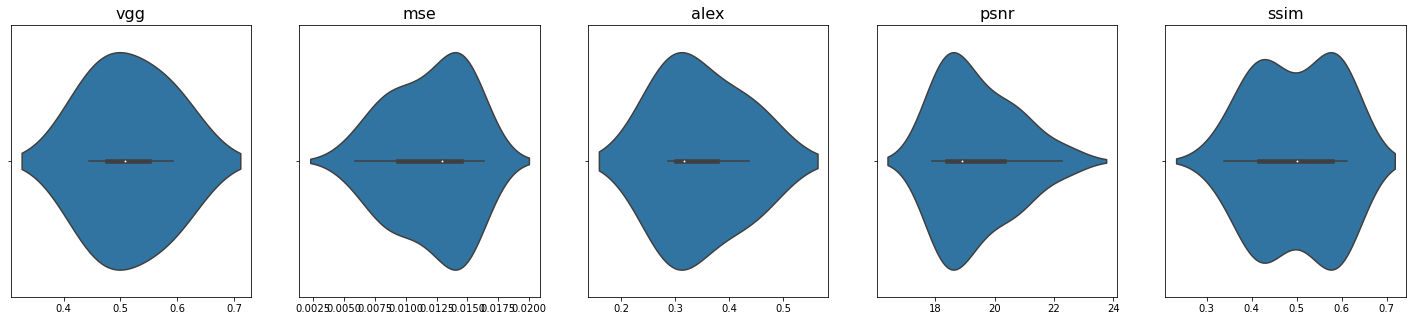

In [68]:
metric_list = [e[:-4] for e in os.listdir(test_metrics_path)]

plt.figure(figsize=(5*len(metric_list),5))
for i, metric in enumerate(metric_list):
    loss = np.load(os.path.join(test_metrics_path, f'{metric}.npy'))

    plt.subplot(1,len(metric_list), i+1)
    sns.violinplot(loss, label='train')
    plt.title(metric, fontsize=16)

plt.show()

# Analyze a group of configurations

In [69]:
filtered_df = df.copy()

desired_dataset = 'LiveFActinDataset' #'EM', 'MitoTracker_small', 'F-actin', 'ER', 'MT', 'MT-SMLM_all']
desired_learning_rate = None # 0.001

if desired_dataset is not None:
    filtered_df = filtered_df[filtered_df['dataset_name'] == desired_dataset]

if desired_learning_rate is not None:
filtered_df = filtered_df[filtered_df['learning_rate'] == desired_learning_rate]



filtered_df.head()


IndentationError: expected an indented block (4143261189.py, line 10)